<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [54]:
## install finrl library
#!pip install git+https://github.com/AI4Finance-Foundation/FinRL-Library.git

In [4]:
%reload_ext autoreload
%autoreload 2


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [82]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
from finrl import config
from finrl import config_tickers
import os


%matplotlib inline
##from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from preprocess.default_preprocessors import FeatureEngineer, data_split 
#from finrl.finrl_meta.preprocessor.CryptoDataReader import CryptoDataLoader
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
#from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, trx_plot


from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [2]:
import os
import numpy as np

from sb3_contrib import RecurrentPPO
from stable_baselines3.common.evaluation import evaluate_policy



<a id='1.4'></a>
## 2.4. Create Folders

In [5]:
root_path = 'MARKETS'
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories

CHOOSEN_MARKET = 'ForexMarket' 

DATA_SAVE_DIR = os.path.join(root_path, CHOOSEN_MARKET, 'DATASET')
TRAINED_MODEL_DIR = os.path.join(root_path, CHOOSEN_MARKET, 'TRAINED_MODEL_DIR')
TENSORBOARD_LOG_DIR = os.path.join(root_path, CHOOSEN_MARKET, 'TENSORBOARD_LOG_DIR')
RESULTS_DIR = os.path.join(root_path, CHOOSEN_MARKET, 'RESULTS_DIR')

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

# Part 3: Download Data



-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


## 3.1 use yahoo finance api to get DOWJONES 

In [ ]:
df = YahooDownloader(start_date = datetime.datetime(2009, 1, 1),
                     end_date = datetime.datetime.now(),
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [6]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [7]:
df.shape

(100570, 8)

In [8]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2008-12-31,3.070357,3.133571,3.047857,2.602663,607541200,AAPL,2
1,2008-12-31,57.110001,58.220001,57.060001,43.587841,6287200,AMGN,2
2,2008-12-31,17.969999,18.750000,17.910000,14.852880,9625600,AXP,2
3,2008-12-31,41.590000,43.049999,41.500000,32.005890,5443100,BA,2
4,2008-12-31,43.700001,45.099998,43.700001,30.416967,6277400,CAT,2


In [12]:
data = df.copy()

## 3.2 read all the forexdata saved in csv  


In [5]:
import pandas as pd
import os

In [6]:
forex_symbols = pd.read_csv(os.path.join(DATA_SAVE_DIR,'forex_stocks_data.csv'))

In [7]:
forex_market_dataset = forex_symbols.drop(columns=['Unnamed: 0'])

In [9]:
forex_market_dataset = forex_symbols

In [8]:
forex_market_dataset.rename(columns={'symbol' : 'tic'}, inplace= True)

#### cleaning forex_symbols dataframe

In [25]:
dates = []
import datetime
for unixdate in forex_market_dataset['date']:
    utcdate = datetime.datetime.fromtimestamp(unixdate).strftime('%Y-%m-%dT%H:%M:%S')
    dates.append(utcdate)

TypeError: an integer is required (got type str)

In [32]:
forex_market_dataset.rename(columns= {'symbol' : 'tic'}, inplace= True)

In [ ]:
forex_market_dataset['date'] = dates

In [ ]:
forex_market_dataset

,close,high,low,open,s,date,volume,tic
0,3419.60000,3423.70000,3412.60000,3420.60000,ok,2022-07-01T10:30:00,463,OANDA:EU50_EUR
1,3438.00000,3444.90000,3401.90000,3419.60000,ok,2022-07-01T11:30:00,1691,OANDA:EU50_EUR
2,3456.00000,3462.90000,3428.90000,3440.00000,ok,2022-07-01T12:30:00,794,OANDA:EU50_EUR
3,3463.90000,3466.00000,3450.90000,3456.90000,ok,2022-07-01T13:30:00,685,OANDA:EU50_EUR
4,3441.00000,3465.90000,3439.90000,3464.90000,ok,2022-07-01T14:30:00,468,OANDA:EU50_EUR
...,...,...,...,...,...,...,...,...
490,0.69773,0.69848,0.69680,0.69834,ok,2022-07-29T20:30:00,3036,OANDA:AUD_USD
491,0.69771,0.69784,0.69713,0.69770,ok,2022-07-29T21:30:00,1886,OANDA:AUD_USD
492,0.69951,0.69952,0.69762,0.69771,ok,2022-07-29T22:30:00,1877,OANDA:AUD_USD
493,0.69864,0.69978,0.69837,0.69950,ok,2022-07-29T23:30:00,2004,OANDA:AUD_USD


In [ ]:
forex_market_dataset.sort_values(['date', 'tic'], ignore_index = True)
forex_market_dataset.drop(columns='s', inplace = True)
forex_market_dataset

,close,high,low,open,date,volume,tic
0,3419.60000,3423.70000,3412.60000,3420.60000,2022-07-01T10:30:00,463,OANDA:EU50_EUR
1,3438.00000,3444.90000,3401.90000,3419.60000,2022-07-01T11:30:00,1691,OANDA:EU50_EUR
2,3456.00000,3462.90000,3428.90000,3440.00000,2022-07-01T12:30:00,794,OANDA:EU50_EUR
3,3463.90000,3466.00000,3450.90000,3456.90000,2022-07-01T13:30:00,685,OANDA:EU50_EUR
4,3441.00000,3465.90000,3439.90000,3464.90000,2022-07-01T14:30:00,468,OANDA:EU50_EUR
...,...,...,...,...,...,...,...
490,0.69773,0.69848,0.69680,0.69834,2022-07-29T20:30:00,3036,OANDA:AUD_USD
491,0.69771,0.69784,0.69713,0.69770,2022-07-29T21:30:00,1886,OANDA:AUD_USD
492,0.69951,0.69952,0.69762,0.69771,2022-07-29T22:30:00,1877,OANDA:AUD_USD
493,0.69864,0.69978,0.69837,0.69950,2022-07-29T23:30:00,2004,OANDA:AUD_USD


## 3.3 : use finnhub to get crypto market data  

In [5]:
api_key='cbj22uqad3i2thcmtg80'
choosen_symbols = ['BTC', 'ETH', 'USDT', 'USDC', 'BNB', 'XRP', 'ADA', 'BUSD', 'SOL', 'DOT']

In [ ]:
data_loader = CryptoDataLoader(symbols_list= choosen_symbols, api_key=api_key)

In [ ]:
crypto_df = data_loader.load_crypto_candles()

In [ ]:
crypto_df

,c,h,l,o,s,t,v,symbol
0,0.06921,0.10000,0.01444,0.01444,ok,1586476800,3695792.1,BINANCE:SOLBNB
1,0.05773,0.07609,0.05568,0.06921,ok,1586563200,1792845.2,BINANCE:SOLBNB
2,0.06188,0.06589,0.05464,0.05756,ok,1586649600,1036908.3,BINANCE:SOLBNB
3,0.05171,0.06188,0.05160,0.06188,ok,1586736000,476803.6,BINANCE:SOLBNB
4,0.04272,0.05264,0.04040,0.05171,ok,1586822400,617685.5,BINANCE:SOLBNB
...,...,...,...,...,...,...,...,...
995,1.23700,1.33100,1.23700,1.31300,ok,1639612800,1450240.9,BINANCE:ADAUSDC
996,1.22200,1.25800,1.18300,1.23900,ok,1639699200,3451131.2,BINANCE:ADAUSDC
997,1.24300,1.26800,1.19900,1.21900,ok,1639785600,658339.6,BINANCE:ADAUSDC
998,1.24400,1.31100,1.24100,1.24200,ok,1639872000,1262579.4,BINANCE:ADAUSDC


In [ ]:
crypto_symbols_df = data_loader.cleansing_holcv_dataframes(crypto_df)

In [ ]:
dates = []
import datetime
for unixdate in crypto_symbols_df['date']:
    utcdate = datetime.datetime.fromtimestamp(unixdate).strftime('%Y-%m-%d')
    dates.append(utcdate)
crypto_symbols_df['date'] = dates

In [ ]:
data = crypto_symbols_df.copy()
data  = data_loader.crypto_clean_data(data)

,close,high,low,open,date,volume,tic
0,0.06921,0.10000,0.01444,0.01444,2020-04-10,3695792.1,BINANCE:SOLBNB
1,0.05773,0.07609,0.05568,0.06921,2020-04-11,1792845.2,BINANCE:SOLBNB
2,0.06188,0.06589,0.05464,0.05756,2020-04-12,1036908.3,BINANCE:SOLBNB
3,0.05171,0.06188,0.05160,0.06188,2020-04-13,476803.6,BINANCE:SOLBNB
4,0.04272,0.05264,0.04040,0.05171,2020-04-14,617685.5,BINANCE:SOLBNB
...,...,...,...,...,...,...,...
995,1.23700,1.33100,1.23700,1.31300,2021-12-16,1450240.9,BINANCE:ADAUSDC
996,1.22200,1.25800,1.18300,1.23900,2021-12-17,3451131.2,BINANCE:ADAUSDC
997,1.24300,1.26800,1.19900,1.21900,2021-12-18,658339.6,BINANCE:ADAUSDC
998,1.24400,1.31100,1.24100,1.24200,2021-12-19,1262579.4,BINANCE:ADAUSDC


In [ ]:
data.to_csv(os.path.join(DATA_SAVE_DIR,'Dataset.csv'))

NameError: name 'data' is not defined

In [6]:
data_name = 'Dataset.csv'
data  = pd.read_csv(os.path.join(DATA_SAVE_DIR,data_name))
data.drop(columns={'Unnamed: 0'}, inplace= True)

## 3.4 :use yahoofinance api to get s&p 500

In [ ]:
import requests
import bs4 as bs
import pickle

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    return tickers

In [ ]:
sp_tickers = save_sp500_tickers()
data = YahooDownloader(start_date = datetime.datetime(2016, 1, 1),
                     end_date = datetime.datetime.now(),
                     ticker_list = sp_tickers).fetch_data()

In [86]:
data = pd.DataFrame(data)
data.to_csv(os.path.join(DATA_SAVE_DIR,'sp500.csv'))

In [5]:
data = pd.read_csv(os.path.join(DATA_SAVE_DIR,'sp500.csv'))
data.drop(columns={'Unnamed: 0'}, inplace= True)

# Part 3 - alternative: Load Data From CSV File




In [6]:
import os

forex_market_dataset = pd.read_csv(os.path.join(DATA_SAVE_DIR, 'forex_data.csv'))

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [7]:
data = forex_market_dataset

In [8]:
data

,Date,Adj Close,Close,High,Low,Open,Volume,tic
0,2019-01-01,1.149306,1.149306,1.155001,1.146500,1.149425,0,EURUSD=X
1,2019-01-02,1.146171,1.146171,1.149700,1.134572,1.146132,0,EURUSD=X
2,2019-01-03,1.131811,1.131811,1.140914,1.131734,1.131734,0,EURUSD=X
3,2019-01-04,1.139108,1.139108,1.141774,1.134816,1.139095,0,EURUSD=X
4,2019-01-07,1.141044,1.141044,1.147447,1.140524,1.141292,0,EURUSD=X
...,...,...,...,...,...,...,...,...
6253,2022-12-26,0.932880,0.932880,0.933900,0.930900,0.932880,0,USDCHF=X
6254,2022-12-27,0.932010,0.932010,0.932090,0.926900,0.932010,0,USDCHF=X
6255,2022-12-28,0.929200,0.929200,0.930600,0.924640,0.929200,0,USDCHF=X
6256,2022-12-29,0.927710,0.927710,0.928720,0.921190,0.927710,0,USDCHF=X


In [9]:
data.drop(columns='Volume', inplace= True)

In [10]:
data.rename(columns={'Date': 'date','Adj Close': 'adj close', 'Close' : 'close', 'High' : 'high', 'Low': 'low', 'Open': 'open'}, inplace= True)

In [9]:
data.tic.unique()

array(['EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'AUDUSD=X', 'USDCAD=X',
       'USDCHF=X'], dtype=object)

In [11]:
from preprocess.default_preprocessors import FeatureEngineer, data_split 
from finrl import config



In [12]:
fe = FeatureEngineer(
                    use_technical_indicator = True,
                    tech_indicator_list =  config.INDICATORS,
                    use_vix= True ,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(data)


Index(['date', 'adj close', 'close', 'high', 'low', 'open', 'tic'], dtype='object')
Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1007, 8)
Successfully added vix
Successfully added turbulence index


In [19]:
processed.tic.unique()

array(['AUDUSD=X', 'EURUSD=X', 'GBPUSD=X', 'USDCAD=X', 'USDCHF=X',
       'USDJPY=X'], dtype=object)

In [20]:
np.where(processed.isna() == True)

(array([], dtype=int64), array([], dtype=int64))

In [21]:
processed.dropna(axis=1)

,date,adj close,close,high,low,open,tic,macd,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2019-01-02,0.704791,0.704791,0.704821,0.698470,0.704722,AUDUSD=X,0.000014,100.000000,-66.666667,100.000000,0.704483,0.704483,23.219999,0.000000
1,2019-01-02,1.146171,1.146171,1.149700,1.134572,1.146132,EURUSD=X,-0.000070,0.000000,-66.666667,100.000000,1.147739,1.147739,23.219999,0.000000
2,2019-01-02,1.275429,1.275429,1.277335,1.258463,1.275234,GBPUSD=X,0.000036,100.000000,-66.666667,100.000000,1.274617,1.274617,23.219999,0.000000
3,2019-01-02,1.362540,1.362540,1.365960,1.356900,1.362500,USDCAD=X,0.000518,100.000000,66.666667,100.000000,1.350985,1.350985,23.219999,0.000000
4,2019-01-02,0.982000,0.982000,0.989250,0.979400,0.981800,USDCHF=X,-0.000034,0.000000,66.666667,100.000000,0.982755,0.982755,23.219999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6031,2022-12-29,1.062925,1.062925,1.067019,1.061233,1.062925,EURUSD=X,0.008925,60.167083,78.327051,49.139568,1.050900,1.022255,21.440001,6.166426
6032,2022-12-29,1.202848,1.202848,1.207584,1.201548,1.203297,GBPUSD=X,0.003764,52.732919,-46.930901,3.480165,1.211069,1.176042,21.440001,6.166426
6033,2022-12-29,1.359940,1.359940,1.360760,1.354450,1.359940,USDCAD=X,0.002138,52.738428,36.079932,8.181686,1.353157,1.357071,21.440001,6.166426
6034,2022-12-29,0.927710,0.927710,0.928720,0.921190,0.927710,USDCHF=X,-0.006936,40.654053,-97.756970,35.855458,0.938252,0.963402,21.440001,6.166426


In [13]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [14]:
processed_full.sort_values(['date','tic'],ignore_index=True)

,date,tic,adj close,close,high,low,open,macd,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2019-01-02,AUDUSD=X,0.704791,0.704791,0.704821,0.698470,0.704722,0.000014,100.000000,-66.666667,100.000000,0.704483,0.704483,23.219999,0.000000
1,2019-01-02,EURUSD=X,1.146171,1.146171,1.149700,1.134572,1.146132,-0.000070,0.000000,-66.666667,100.000000,1.147739,1.147739,23.219999,0.000000
2,2019-01-02,GBPUSD=X,1.275429,1.275429,1.277335,1.258463,1.275234,0.000036,100.000000,-66.666667,100.000000,1.274617,1.274617,23.219999,0.000000
3,2019-01-02,USDCAD=X,1.362540,1.362540,1.365960,1.356900,1.362500,0.000518,100.000000,66.666667,100.000000,1.350985,1.350985,23.219999,0.000000
4,2019-01-02,USDCHF=X,0.982000,0.982000,0.989250,0.979400,0.981800,-0.000034,0.000000,66.666667,100.000000,0.982755,0.982755,23.219999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6031,2022-12-29,EURUSD=X,1.062925,1.062925,1.067019,1.061233,1.062925,0.008925,60.167083,78.327051,49.139568,1.050900,1.022255,21.440001,6.166426
6032,2022-12-29,GBPUSD=X,1.202848,1.202848,1.207584,1.201548,1.203297,0.003764,52.732919,-46.930901,3.480165,1.211069,1.176042,21.440001,6.166426
6033,2022-12-29,USDCAD=X,1.359940,1.359940,1.360760,1.354450,1.359940,0.002138,52.738428,36.079932,8.181686,1.353157,1.357071,21.440001,6.166426
6034,2022-12-29,USDCHF=X,0.927710,0.927710,0.928720,0.921190,0.927710,-0.006936,40.654053,-97.756970,35.855458,0.938252,0.963402,21.440001,6.166426


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [15]:
processed_full['date'].max()

'2022-12-29'

## Training data and Trading data split

In [16]:
# from config.py TRAIN_START_DATE is a string
#config.TRAIN_START_DATE
train_start_date = datetime.datetime(2019,1,1).strftime('%Y-%m-%d')
# from config.py TRAIN_END_DATE is a string
train_end_date = datetime.datetime(2022,1,1).strftime('%Y-%m-%d')
trade_end_date = datetime.datetime(2023,1,1).strftime('%Y-%m-%d')
train = data_split(processed_full, train_start_date ,train_end_date)
trade = data_split(processed_full, train_end_date ,trade_end_date)
print(len(train))
print(len(trade))

4536
1500


In [17]:
train.tail()

,date,tic,adj close,close,high,low,open,macd,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
755,2021-12-31,EURUSD=X,1.132503,1.132503,1.137915,1.130506,1.132323,-0.000965,44.911151,109.118753,16.257448,1.129425,1.142246,17.219999,3.822869
755,2021-12-31,GBPUSD=X,1.349837,1.349837,1.354848,1.346747,1.349892,0.002156,52.327576,171.604444,30.393030,1.332000,1.347087,17.219999,3.822869
755,2021-12-31,USDCAD=X,1.274440,1.274440,1.275000,1.262680,1.274300,0.003544,52.687505,-70.077708,14.859173,1.277305,1.260555,17.219999,3.822869
755,2021-12-31,USDCHF=X,0.913700,0.913700,0.914740,0.910470,0.913900,-0.002014,44.964408,-170.194575,37.535785,0.922676,0.921276,17.219999,3.822869
755,2021-12-31,USDJPY=X,115.063004,115.063004,115.192001,115.004997,115.058998,0.301309,59.394022,120.417399,32.024355,114.023701,113.945000,17.219999,3.822869


In [27]:
trade.tail()

,date,tic,adj close,close,high,low,open,macd,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
249,2022-12-29,EURUSD=X,1.062925,1.062925,1.067019,1.061233,1.062925,0.008925,60.167083,78.327051,49.139568,1.050900,1.022255,21.440001,6.166426
249,2022-12-29,GBPUSD=X,1.202848,1.202848,1.207584,1.201548,1.203297,0.003764,52.732919,-46.930901,3.480165,1.211069,1.176042,21.440001,6.166426
249,2022-12-29,USDCAD=X,1.359940,1.359940,1.360760,1.354450,1.359940,0.002138,52.738428,36.079932,8.181686,1.353157,1.357071,21.440001,6.166426
249,2022-12-29,USDCHF=X,0.927710,0.927710,0.928720,0.921190,0.927710,-0.006936,40.654053,-97.756970,35.855458,0.938252,0.963402,21.440001,6.166426
249,2022-12-29,USDJPY=X,134.033997,134.033997,134.188004,132.936005,134.033997,-1.870648,41.564990,-88.398318,29.149269,136.605233,141.392699,21.440001,6.166426


In [18]:
config.INDICATORS

['macd', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']

In [19]:
stock_dimension = len(train.tic.unique())
state_space = 1 + len(config.INDICATORS)*stock_dimension + 2*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 6, State Space: 49


In [26]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [31]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


/home/mohammad/miniconda3/envs/Finrl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")
model_a2c.pre

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [ ]:
model_name = 'a2c_'
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)
trained_a2c.save(os.path.join(TRAINED_MODEL_DIR, model_name + ".pth"))

---------------------------------------
| time/                 |             |
|    fps                | 58          |
|    iterations         | 100         |
|    time_elapsed       | 8           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -96.5       |
|    explained_variance | -52.8       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -16.7       |
|    reward             | 0.044553936 |
|    std                | 1.02        |
|    value_loss         | 0.0917      |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 69           |
|    iterations         | 200          |
|    time_elapsed       | 14           |
|    total_timesteps    | 1000         |
| train/                |              |
|    entropy_loss       | -97.4        |
|    explained_variance | -9.89 

### Model 2: DDPG

In [32]:
from stable_baselines3.common.utils import get_schedule_fn
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50, "learning_rate": 0.0025}
model_ddpg = agent.get_model("ddpg",model_kwargs= DDPG_PARAMS,  tensorboard_log = TENSORBOARD_LOG_DIR)

{'batch_size': 128, 'buffer_size': 50, 'learning_rate': 0.0025}
Using cuda device


In [33]:
model_name  = 'DDPG_'
total_timesteps = 1000000
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=total_timesteps)
trained_ddpg.save(os.path.join(TRAINED_MODEL_DIR, model_name + str(total_timesteps) + ".pth"))

Logging to MARKETS/ForexMarket/TENSORBOARD_LOG_DIR/ddpg_3
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 188       |
|    time_elapsed    | 16        |
|    total_timesteps | 3024      |
| train/             |           |
|    actor_loss      | -88.2     |
|    critic_loss     | 22.3      |
|    learning_rate   | 0.0025    |
|    n_updates       | 2268      |
|    reward          | 0.1039026 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 196       |
|    time_elapsed    | 30        |
|    total_timesteps | 6048      |
| train/             |           |
|    actor_loss      | -51       |
|    critic_loss     | 19.8      |
|    learning_rate   | 0.0025    |
|    n_updates       | 5292      |
|    reward          | 0.1039026 |
----------------------------------
day: 755, episode: 10
begin_tota

In [34]:
TENSORBOARD_LOG_DIR

[autoreload of stable_baselines3.common.logger failed: Traceback (most recent call last):
  File "/home/mohammad/miniconda3/envs/Finrl/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/mohammad/miniconda3/envs/Finrl/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/mohammad/miniconda3/envs/Finrl/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/mohammad/miniconda3/envs/Finrl/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/home/mohammad/miniconda3/envs/Finrl/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 319, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]
[autoreload of stable_baselines3.common.type_aliases f

### Model 3: PPO

In [75]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = config.PPO_PARAMS
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS, tensorboard_log= TENSORBOARD_LOG_DIR)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device


In [76]:
model_ppo.device

device(type='cuda')

In [77]:
model_name  = 'ppo_'
model_version = '50000'
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)
trained_ppo.save(os.path.join(TRAINED_MODEL_DIR, model_name + ".pth"))

Logging to MARKETS/ForexMarket/TENSORBOARD_LOG_DIR/ppo_1
day: 521, episode: 120
begin_total_asset: 1000000.00
end_total_asset: 999930.23
total_reward: -69.77
total_cost: 28.03
total_trades: 477
Sharpe: -1.430
--------------------------------------
| time/              |               |
|    fps             | 125           |
|    iterations      | 1             |
|    time_elapsed    | 16            |
|    total_timesteps | 2048          |
| train/             |               |
|    reward          | -0.0018495668 |
--------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 109            |
|    iterations           | 2              |
|    time_elapsed         | 37             |
|    total_timesteps      | 4096           |
| train/                  |                |
|    approx_kl            | 0.00394472     |
|    clip_fraction        | 0.03           |
|    clip_range           | 0.2    

### Model 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [ ]:
model_name ='td3_'
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)
trained_td3.save(os.path.join(TRAINED_MODEL_DIR, model_name + ".pth"))

### Model 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [ ]:
model_name = 'sac_'
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)
trained_sac.save(os.path.join(TRAINED_MODEL_DIR, model_name + ".pth"))

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 23        |
|    time_elapsed    | 63        |
|    total_timesteps | 1508      |
| train/             |           |
|    actor_loss      | 1.22e+03  |
|    critic_loss     | 7.89e+03  |
|    ent_coef        | 0.115     |
|    ent_coef_loss   | 1.08e+03  |
|    learning_rate   | 0.0001    |
|    n_updates       | 1407      |
|    reward          | 4.9791036 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 19        |
|    time_elapsed    | 156       |
|    total_timesteps | 3016      |
| train/             |           |
|    actor_loss      | 1.66e+03  |
|    critic_loss     | 8.25e+03  |
|    ent_coef        | 0.134     |
|    ent_coef_loss   | 1.01e+03  |
|    learning_rate   | 0.0001    |
|    n_updates       | 2915      |
|    reward         

KeyboardInterrupt: 

### Model 6: recurrentppo

In [74]:
model = RecurrentPPO("MlpLstmPolicy", env=env_train, verbose=1)
model.learn(50000)
model_version = '50000_iter_'
model_name = 'recurrent_ppo'

env = model.get_env()
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20, warn=False)
print(mean_reward)

model.save(os.path.join(TRAINED_MODEL_DIR, model_version + model_name  + ".pth"))

Using cuda device
----------------------------
| time/              |     |
|    fps             | 13  |
|    iterations      | 1   |
|    time_elapsed    | 9   |
|    total_timesteps | 128 |
----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 13         |
|    iterations           | 2          |
|    time_elapsed         | 19         |
|    total_timesteps      | 256        |
| train/                  |            |
|    approx_kl            | 0.15408333 |
|    clip_fraction        | 0.392      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.863     |
|    explained_variance   | -0.28      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.465      |
|    n_updates            | 10         |
|    policy_gradient_loss | 0.431      |
|    std                  | 0.998      |
|    value_loss           | 0.00468    |
----------------------------------------


# Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [20]:
data_risk_indicator = processed_full[(processed_full.date<trade_end_date) & (processed_full.date> train_end_date)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [21]:
insample_risk_indicator.vix.describe()

count    250.000000
mean      25.639720
std        4.216336
min       16.600000
25%       22.230000
50%       25.505000
75%       28.930001
max       36.450001
Name: vix, dtype: float64

In [22]:
insample_risk_indicator.vix.quantile(0.996)

35.13528106689452

In [23]:
insample_risk_indicator.turbulence.describe()

count    250.000000
mean      10.574578
std       12.101466
min        0.451542
25%        4.143907
50%        7.096417
75%       13.162082
max       89.601229
Name: turbulence, dtype: float64

In [24]:
insample_risk_indicator.turbulence.quantile(0.996)

88.29403926590331

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [27]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [28]:
trade.head()

,date,tic,adj close,close,high,low,open,macd,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2022-01-03,AUDUSD=X,0.726818,0.726818,0.727908,0.718590,0.726850,0.001099,51.288051,104.966545,3.520604,0.716629,0.728673,16.6,6.664439
0,2022-01-03,EURUSD=X,1.137346,1.137346,1.137592,1.128541,1.137385,-0.000456,47.814245,122.620797,9.183568,1.129750,1.141925,16.6,6.664439
0,2022-01-03,GBPUSD=X,1.352228,1.352228,1.353180,1.343274,1.352228,0.003050,53.283006,154.852691,21.800040,1.332292,1.346930,16.6,6.664439
0,2022-01-03,USDCAD=X,1.265880,1.265880,1.277810,1.264400,1.265710,0.002133,48.905144,-87.188526,9.888084,1.277323,1.260846,16.6,6.664439
0,2022-01-03,USDCHF=X,0.911975,0.911975,0.919910,0.911500,0.912030,-0.002360,43.914787,-136.171788,14.666355,0.922099,0.921011,16.6,6.664439


In [29]:
model_name = 'DDPG_100000.pth'
train_model_path = os.path.join(TRAINED_MODEL_DIR, model_name)
trained_ddpg = DRLAgent.DRL_load_from_file(model_name = 'ddpg' ,
    cwd=train_model_path)

Successfully load model MARKETS/ForexMarket/TRAINED_MODEL_DIR/DDPG_100000.pth


In [30]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment=e_trade_gym)

/home/mohammad/miniconda3/envs/Finrl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


hit end!


In [57]:
import os
action_value_df = pd.merge(df_actions, df_account_value,on='date')
action_value_df.to_csv(os.path.join(RESULTS_DIR,'ddpg_100000_total_timesteps_actions_account_value.csv'))

In [59]:
df_actions

,AUDUSD=X,EURUSD=X,GBPUSD=X,USDCAD=X,USDCHF=X,USDJPY=X
date,,,,,,
2022-01-03,100,0,0,100,100,100
2022-01-04,100,0,0,100,100,100
2022-01-05,100,0,0,100,100,100
2022-01-06,100,0,0,100,100,100
2022-01-07,100,0,0,100,100,100
...,...,...,...,...,...,...
2022-12-21,0,0,0,0,0,0
2022-12-22,0,0,0,0,0,0
2022-12-23,0,0,0,0,0,0


### Trade by recurrentppo

we use recurrent ppo as alternative to finrl's drl agents beacause our env is partially observable and we need memory so we use recurrent ppo (lstm ppo) for using of recurrent prediction 


In [53]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade,  turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

/home/mohammad/miniconda3/envs/Finrl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [55]:
os.path.join(TRAINED_MODEL_DIR,  model_version + model_version + ".pth")

'MARKETS/ForexMarket/TRAINED_MODEL_DIR/1000000DDPG_.pth'

In [56]:
model_version = '1000000'
model_name = 'DDPG_'
model = RecurrentPPO.load(os.path.join(TRAINED_MODEL_DIR,  model_name + model_version + ".pth"))

TypeError: TD3Policy.__init__() got an unexpected keyword argument 'use_sde'

In [31]:
account_memory = []
actions_memory = []
lstm_states = None
num_envs = 1
episode_starts = np.ones((num_envs,), dtype=bool)
#         state_memory=[] #add memory pool to store states
env_trade.reset()
for i in range(len(e_trade_gym.df.index.unique())):
    action, lstm_states = model.predict(obs_trade, state=lstm_states, episode_start=episode_starts, deterministic=True)
            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
    obs_trade, rewards, dones, info = env_trade.step(action)
    episode_starts = dones
    env_trade.render()
    if i == (len(e_trade_gym.df.index.unique()) - 2):
        account_memory = env_trade.env_method(method_name="save_asset_memory")
        actions_memory = env_trade.env_method(method_name="save_action_memory")
#                 state_memory=test_env.env_method(method_name="save_state_memory") # add current state to state memory
    if dones[0]:
        print(i)
        print("hit end!")


105
hit end!


In [52]:
df_account_value = pd.DataFrame(account_memory[0])
df_actions_memory = pd.DataFrame(actions_memory[0])

NameError: name 'account_memory' is not defined

In [33]:
df_account_value

,date,account_value
0,2021-04-26,1.000000e+06
1,2021-04-27,1.017711e+06
2,2021-04-28,1.014192e+06
3,2021-04-29,9.902239e+05
4,2021-04-30,1.067545e+06
...,...,...
101,2021-09-17,8.741583e+05
102,2021-09-20,7.944693e+05
103,2021-09-21,7.521426e+05
104,2021-09-22,8.052165e+05


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [35]:
print("==============Get Backtest Results===========")

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all

==============Get Backtest Results===========
Annual return          0.126088
Cumulative returns     0.125027
Annual volatility      0.111443
Sharpe ratio           1.125815
Calmar ratio           1.053380
Stability              0.780501
Max drawdown          -0.119698
Omega ratio            1.230706
Sortino ratio          1.533858
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.870876
Daily value at risk   -0.013543
dtype: float64


,0
Annual return,0.126088
Cumulative returns,0.125027
Annual volatility,0.111443
Sharpe ratio,1.125815
Calmar ratio,1.053380
Stability,0.780501
Max drawdown,-0.119698
Omega ratio,1.230706
Sortino ratio,1.533858
Skew,NaN


In [42]:
#baseline stats
print("==============Get Baseline Stats===========")

stats = backtest_stats(trade, value_col_name = 'adj close')
stats.to_csv(os.path.join(RESULTS_DIR,'baseline_stats' + ".csv"))


==============Get Baseline Stats===========
Annual return          1.402440e+00
Cumulative returns     1.834120e+02
Annual volatility      8.110592e+02
Sharpe ratio           7.051340e+00
Calmar ratio           1.408338e+00
Stability              4.270229e-07
Max drawdown          -9.958126e-01
Omega ratio            1.079497e+02
Sortino ratio          8.579339e+02
Skew                            NaN
Kurtosis                        NaN
Tail ratio             1.433154e+02
Daily value at risk   -7.948919e+01
dtype: float64


In [58]:
stats

Annual return          1.402440e+00
Cumulative returns     1.834120e+02
Annual volatility      8.110592e+02
Sharpe ratio           7.051340e+00
Calmar ratio           1.408338e+00
Stability              4.270229e-07
Max drawdown          -9.958126e-01
Omega ratio            1.079497e+02
Sortino ratio          8.579339e+02
Skew                            NaN
Kurtosis                        NaN
Tail ratio             1.433154e+02
Daily value at risk   -7.948919e+01
dtype: float64

In [60]:
stocks = trade['tic'].unique()

In [32]:
df_account_value.loc[len(df_account_value)-1,'date']

'2022-12-29'

In [ ]:
stock_items = ['start']

<a id='6.2'></a>
## 7.2 BackTestPlot

In [71]:
sma_period = 1
stock_symbol = stocks[0]
stock_data = trade[trade['tic'] == stock_symbol]
stock_data ['SMA'] = stock_data['adj close'].rolling(window=sma_period).mean()

/tmp/ipykernel_1519/1491087412.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data ['SMA'] = stock_data['adj close'].rolling(window=sma_period).mean()


In [72]:
stock_data

,date,tic,adj close,close,high,low,open,macd,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,SMA
0,2022-01-03,AUDUSD=X,0.726818,0.726818,0.727908,0.718590,0.726850,0.001099,51.288051,104.966545,3.520604,0.716629,0.728673,16.600000,6.664439,0.726818
1,2022-01-04,AUDUSD=X,0.719800,0.719800,0.724900,0.718530,0.719690,0.000856,47.194235,61.427910,3.674852,0.716529,0.728422,16.910000,6.206088,0.719800
2,2022-01-05,AUDUSD=X,0.723880,0.723880,0.727180,0.722340,0.724108,0.000981,49.613136,103.112212,2.658069,0.716584,0.728262,19.730000,13.829550,0.723880
3,2022-01-06,AUDUSD=X,0.722080,0.722080,0.722300,0.714660,0.722300,0.000925,48.597134,40.234807,15.847883,0.716647,0.727986,19.610001,7.176280,0.722080
4,2022-01-07,AUDUSD=X,0.716260,0.716260,0.718592,0.713109,0.716399,0.000406,45.482040,-8.628733,18.999867,0.716610,0.727568,18.760000,13.874675,0.716260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2022-12-22,AUDUSD=X,0.671682,0.671682,0.676800,0.667000,0.671682,0.002759,51.917093,-12.603217,0.841755,0.672561,0.655427,21.969999,6.532908,0.671682
246,2022-12-23,AUDUSD=X,0.667800,0.667800,0.671321,0.666138,0.667800,0.002126,50.526158,-67.043650,0.600092,0.672798,0.655702,20.870001,2.297701,0.667800
247,2022-12-27,AUDUSD=X,0.674459,0.674459,0.678000,0.672580,0.674459,0.001923,52.807147,29.541345,10.095464,0.673020,0.656593,21.650000,4.062184,0.674459
248,2022-12-28,AUDUSD=X,0.672993,0.672993,0.680100,0.672011,0.672993,0.001817,52.248812,30.985523,13.389150,0.672888,0.656952,22.139999,3.726654,0.672993


In [67]:
stock_data

,date,tic,adj close,close,high,low,open,macd,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,SMA
0,2022-01-03,USDJPY=X,115.141998,115.141998,115.360001,114.973999,115.136002,0.336429,59.785097,119.022871,35.751020,114.057167,113.992867,16.600000,6.664439,NaN
1,2022-01-04,USDJPY=X,115.328003,115.328003,116.339996,115.299004,115.316002,0.374949,60.706895,161.120593,52.119439,114.075101,114.025200,16.910000,6.206088,NaN
2,2022-01-05,USDJPY=X,116.174004,116.174004,116.235001,115.626999,116.165001,0.468343,64.532095,185.233395,52.119439,114.109534,114.069451,19.730000,13.829550,NaN
3,2022-01-06,USDJPY=X,116.127998,116.127998,116.179001,115.653999,116.128998,0.532507,64.180614,174.712336,52.119439,114.133534,114.116567,19.610001,7.176280,NaN
4,2022-01-07,USDJPY=X,115.864998,115.864998,116.029999,115.591003,115.870003,0.555730,62.177831,143.956861,49.136100,114.160067,114.150417,18.760000,13.874675,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2022-12-22,USDJPY=X,132.369995,132.369995,132.681000,131.654999,132.369995,-1.924860,38.041798,-178.880110,43.783778,137.747166,142.335549,21.969999,6.532908,141.935759
246,2022-12-23,USDJPY=X,132.356995,132.356995,133.121002,132.291000,132.356995,-2.040124,38.025650,-156.463915,39.466543,137.434600,142.134316,20.870001,2.297701,141.648159
247,2022-12-27,USDJPY=X,132.764008,132.764008,133.587006,132.647995,132.764008,-2.076570,38.884193,-124.042215,34.652173,136.964133,141.737966,21.650000,4.062184,141.357579
248,2022-12-28,USDJPY=X,133.485992,133.485992,134.395004,133.410995,133.485992,-1.998389,40.415416,-93.656085,26.430901,136.781500,141.566282,22.139999,3.726654,141.054659


In [83]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value,  
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'],
             baseline_ticker = stock_data,
             value_col_name= 'SMA')

==============Compare to DJIA===========


KeyError: 'date'

In [49]:
trade[trade['tic'] == stocks[0]] 

,date,tic,adj close,close,high,low,open,macd,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2022-01-03,AUDUSD=X,0.726818,0.726818,0.727908,0.718590,0.726850,0.001099,51.288051,104.966545,3.520604,0.716629,0.728673,16.600000,6.664439
1,2022-01-04,AUDUSD=X,0.719800,0.719800,0.724900,0.718530,0.719690,0.000856,47.194235,61.427910,3.674852,0.716529,0.728422,16.910000,6.206088
2,2022-01-05,AUDUSD=X,0.723880,0.723880,0.727180,0.722340,0.724108,0.000981,49.613136,103.112212,2.658069,0.716584,0.728262,19.730000,13.829550
3,2022-01-06,AUDUSD=X,0.722080,0.722080,0.722300,0.714660,0.722300,0.000925,48.597134,40.234807,15.847883,0.716647,0.727986,19.610001,7.176280
4,2022-01-07,AUDUSD=X,0.716260,0.716260,0.718592,0.713109,0.716399,0.000406,45.482040,-8.628733,18.999867,0.716610,0.727568,18.760000,13.874675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2022-12-22,AUDUSD=X,0.671682,0.671682,0.676800,0.667000,0.671682,0.002759,51.917093,-12.603217,0.841755,0.672561,0.655427,21.969999,6.532908
246,2022-12-23,AUDUSD=X,0.667800,0.667800,0.671321,0.666138,0.667800,0.002126,50.526158,-67.043650,0.600092,0.672798,0.655702,20.870001,2.297701
247,2022-12-27,AUDUSD=X,0.674459,0.674459,0.678000,0.672580,0.674459,0.001923,52.807147,29.541345,10.095464,0.673020,0.656593,21.650000,4.062184
248,2022-12-28,AUDUSD=X,0.672993,0.672993,0.680100,0.672011,0.672993,0.001817,52.248812,30.985523,13.389150,0.672888,0.656952,22.139999,3.726654


# part7 : manual backtesting

In [81]:
trx_plot(trade, df_actions, list(processed_full['tic'].unique()) )


KeyError: 'transactions'

# tensorboard


In [34]:
model_name = 'recurrent_ppo'

In [62]:
from SaveResultsByTensorboard.tflogtodf import tflog2pandas
path="/mnt/f/financial_projects/Deep Reinforcement Learning Approaches on Stock Prediction/FinRL/Crypto_market/TENSORBOARD_LOG_DIR/ppo_1/events.out.tfevents.1660815830.mohammad-pc.257.0"
df=tflog2pandas(path)



adding training_metric to tensorboard

In [35]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import os

In [36]:
def add_scalar(writer, informations):
    for i in range(len(informations)) :
        info = informations.loc[i]
        writer.add_scalars('train_info', {info['metric'] : info['value'] } , info['step'])

writer = SummaryWriter(os.path.join(TENSORBOARD_LOG_DIR, model_name))
for metric in df['metric'].unique() :
    train_info = df[df['metric']== metric]
    add_scalar(writer, train_info)
writer.close()






NameError: name 'df' is not defined

adding test time info to tensorboard

In [37]:
writer = SummaryWriter(os.path.join(TENSORBOARD_LOG_DIR, model_name))
for i in range(len(df_account_value)) :
    date, account_value = df_account_value.loc[i] 
    writer.add_scalars(main_tag='test', tag_scalar_dict = {'account_value': account_value}, global_step = i) 
writer.close()

adding portfolio visualization to tensorboard

In [77]:
import matplotlib.pyplot as plt

def visualize_portfolio(total, tickers):
    
    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_facecolor('black')
    ax.figure.set_facecolor('#121212')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.set_title("NEURALNINE PORTFOLIO VISUALIZER", color='#EF6C35', fontsize=20)

    patches, texts, autotexts = ax.pie([abs(total_element) for total_element in total], labels=tickers, autopct='%1.1f%%', pctdistance=0.8)
    [text.set_color('white') for text in texts]
    my_circle = plt.Circle((0, 0), 0.55, color='black')
    plt.gca().add_artist(my_circle)

    ax.text(-2,1, 'PORTFOLIO OVERVIEW:', fontsize=14, color="#ffe536", horizontalalignment='center', verticalalignment='center')
    ax.text(-2,0.85, f'Total USD Amount: {sum(total):.2f} $', fontsize=12, color="white", horizontalalignment='center', verticalalignment='center')
    counter = 0.15
    for ticker in tickers:
        ax.text(-2, 0.85 - counter, f'{ticker}: {total[tickers.index(ticker)]:.2f} $', fontsize=12, color="white",
        horizontalalignment='center', verticalalignment='center')
        counter += 0.15
    return fig

In [39]:
def add_image_to_tensorboard(specific_tag ,specific_figure):
    writer = SummaryWriter(os.path.join(TENSORBOARD_LOG_DIR, model_name, 'image'))
    writer.add_figure(tag= specific_tag, figure = specific_figure)
    print('done')
    writer.close()

In [40]:
df_actions.isna().sum()

BINANCE:ADABNB      0
BINANCE:ADABTC      0
BINANCE:ADAETH      0
BINANCE:ADAUSDC     0
BINANCE:ADAUSDT     0
BINANCE:BNBBTC      0
BINANCE:BNBBUSD     0
BINANCE:BNBETH      0
BINANCE:BNBUSDC     0
BINANCE:BNBUSDT     0
BINANCE:BTCBUSD     0
BINANCE:BTCUSDC     0
BINANCE:BTCUSDT     0
BINANCE:BUSDUSDT    0
BINANCE:ETHBTC      0
BINANCE:ETHBUSD     0
BINANCE:ETHUSDC     0
BINANCE:ETHUSDT     0
BINANCE:USDCUSDT    0
BINANCE:XRPBNB      0
BINANCE:XRPBTC      0
BINANCE:XRPBUSD     0
BINANCE:XRPETH      0
BINANCE:XRPUSDC     0
BINANCE:XRPUSDT     0
dtype: int64

In [79]:
def visualize_process(total_val) :
    if total_val == 0 :
        return 0 , 'white'
    elif total_val > 0:
        return 1 , 'green'
    elif total_val < 0 :
        return -1 , 'red'



/tmp/ipykernel_1519/3637531764.py:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  flag, color = visualize_process(int(amounts * prices))
/tmp/ipykernel_1519/3637531764.py:18: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  buy_total.append(int(amounts * prices))


NameError: name 'add_image_to_tensorboard' is not defined

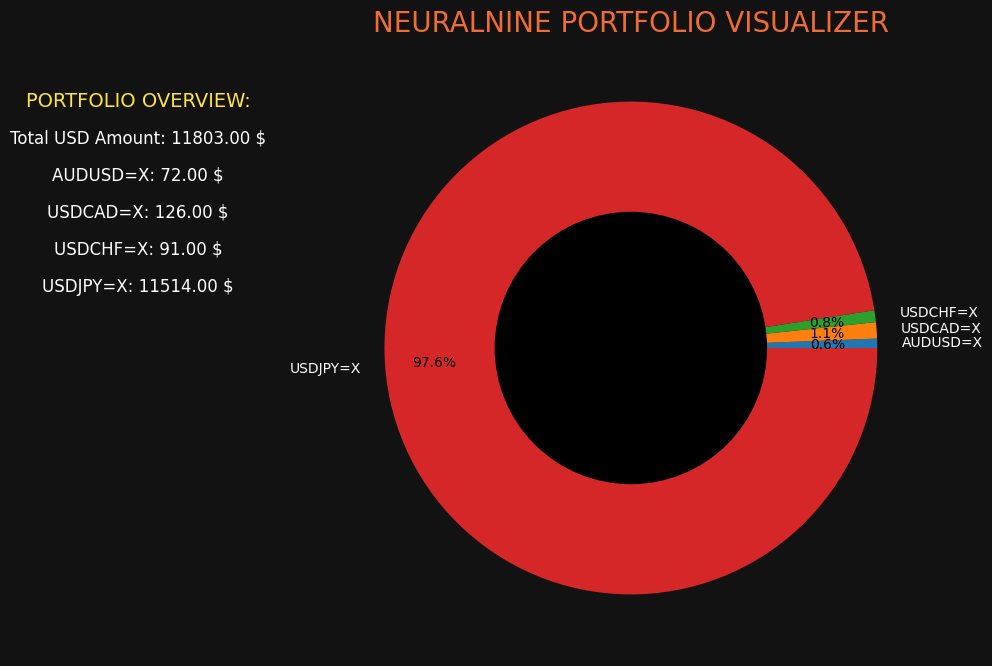

In [80]:
import time
tickers = list(trade['tic'].unique())
dates = df_actions.index
step = 0
for date in dates :
    sell_total = []
    sell_position_tickers = []
    buy_total = []
    buy_position_tickers = []
    step += 1
    for tic in tickers :
        amounts = df_actions.loc[date, tic]
        choosen_trade = trade[trade['date'] == date] 
        choosen_trade = choosen_trade[choosen_trade['tic'] == tic]
        prices = choosen_trade['close']
        flag, color = visualize_process(int(amounts * prices))
        if flag == 1:
            buy_total.append(int(amounts * prices))
            buy_position_tickers.append(tic)
        elif flag == -1:
            sell_total.append(int(amounts * prices))
            sell_position_tickers.append(tic)

    if len(buy_total) != 0 :
        buy_fig = visualize_portfolio(total=buy_total, tickers= buy_position_tickers)
        add_image_to_tensorboard(f"buy_portfolio:{step}", buy_fig)

    if len(sell_total) != 0 :
        sell_fig = visualize_portfolio(total=sell_total, tickers= sell_position_tickers)
        add_image_to_tensorboard(f"sell_portfolio:{step}", sell_fig)

In [125]:
writer = SummaryWriter(os.path.join(TENSORBOARD_LOG_DIR, 'ppo', 'Graph'))
writer.add_graph(trained_ppo, e_trade_gym)

ImportError: cannot import name 'metanet_pb2' from partially initialized module 'caffe2.proto' (most likely due to a circular import) (/home/mohammad/anaconda3/envs/FinRl/lib/python3.8/site-packages/caffe2/proto/__init__.py)

In [122]:
!tensorboard --logdir==runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.1 at http://localhost:6007/ (Press CTRL+C to quit)
^C


In [133]:
model.action_space

Box([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.], (28,), float32)

In [135]:
len(processed_full['tic'].unique())

25